# T81-558: Applications of Deep Neural Networks
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), School of Engineering and Applied Science, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

**Kaggle Assignment: **

**Student Name: Jason Walker**

# Overview

## Description
This is one of the projects from the course T81-855: Applications of Deep Learning at Washington University in St. Louis. All students must create a Kaggle account and submit a solution. Once you have submitted your solution entry log into Blackboard (at WUSTL) and submit a single file telling me your Kaggle name on the leaderboard (you do not need to register to Kaggle with your real name). This competition will be visible to the public, so there may be non-student submissions as well as student.

The data set for this competition consists of a number of input columns that should be used to predict a stores sales. This is a regression problem. The inputs are a mixture of discrete and category values. The data set is from a simulation.

## Evaluation

The evaluation pages describes how submissions will be scored and how students should format their submissions. The scores are in RMSE.
Submission Format

For every store in the dataset, submission files should contain a sales volume.

The file should contain a header and have the following format:

```
100000,1.23
100001,1.123
100002,3.332
100003,1.53
...
```

# Data

## Data Description

The data contains data and costs for various office supplies. The data came from a simulation and do not directly correspond to any real-world items. See how well you can predict the cost of an item using the provided data. Feature engineering will likely help you. The *name* column may seem useless at first glance; however, it contains information that you can parse to help your predictions.
File descriptions
```
    id - The identifier/primary key.
    name - The name of this item.
    manufacturer - The manufacturer.
    pack - The number of items in this pack.
    weight - The weight of a pack of these items.
    height - The height of a pack of these items.
    width - The width of a pack of these items.
    length - The length of a pack of these items.
    cost - The cost for this item pack. This is what you are to predict (the target). 
```

# Helpful Functions

You will see these at the top of every module and assignment.  These are simply a set of reusable functions that we will make use of.  Each of them will be explained as the semester progresses.  They are explained in greater detail as the course progresses.  Class 4 contains a complete overview of these functions.

In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
        
# This function submits an assignment.  You can submit an assignment as much as you like, only the final
# submission counts.  The paramaters are as follows:
# data - Pandas dataframe output.
# key - Your student key that was emailed to you.
# no - The assignment class number, should be 1 through 1.
# source_file - The full path to your Python or IPYNB file.  This must have "_class1" as part of its name.  
# .             The number must match your assignment number.  For example "_class2" for class assignment #2.
def submit(data,key,no,source_file=None):
    if source_file is None and '__file__' not in globals(): raise Exception('Must specify a filename when a Jupyter notebook.')
    if source_file is None: source_file = __file__
    suffix = '_class{}'.format(no)
    if suffix not in source_file: raise Exception('{} must be part of the filename.'.format(suffix))
    with open(source_file, "rb") as image_file:
        encoded_python = base64.b64encode(image_file.read()).decode('ascii')
    ext = os.path.splitext(source_file)[-1].lower()
    if ext not in ['.ipynb','.py']: raise Exception("Source file is {} must be .py or .ipynb".format(ext))
    r = requests.post("https://api.heatonresearch.com/assignment-submit",
        headers={'x-api-key':key}, json={'csv':base64.b64encode(data.to_csv(index=False).encode('ascii')).decode("ascii"),
        'assignment': no, 'ext':ext, 'py':encoded_python})
    if r.status_code == 200:
        print("Success: {}".format(r.text))
    else: print("Failure: {}".format(r.text))

# Kaggle Code



In [76]:
import os
import re
import sklearn

import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn import metrics
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split, KFold
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers

path = './data'

filename_test = os.path.join(path,"test.csv")
filename_train = os.path.join(path,"train.csv")
filename_sample = os.path.join(path,"sample.csv")
filename_submit = os.path.join(path,"submit.csv")
filename_checkpoint = os.path.join(path,"checkpoint.hdf5")

df_train = pd.read_csv(filename_train,na_values=['NA','?'])

np.random.seed(42) # Uncomment this line to get the same shuffle each time
df_train = df_train.reindex(np.random.permutation(df_train.index))
df_train.reset_index(inplace=True, drop=True)

# Encode Features

# Remove all rows where the specified column is +/- sd standard deviations
def extract_and_encode_features(df):
    color_regex='(?P<color>red|blue|green|yellow|orange|pink|black|brown|white)'
    df['color'] = df.name.str.extract(color_regex, flags=re.IGNORECASE, expand=False)

    quality_regex='(?P<quality>generic|medium\shigh\squality|high\squality)'
    df['quality'] = df.name.str.extract(quality_regex, flags=re.IGNORECASE, expand=False)

    size_regex='(?P<size>tiny|small|medium|large)'
    df['size'] = df.name.str.extract(size_regex, flags=re.IGNORECASE, expand=False)

    item_regex='(?P<item>paperclips|paperweights|ink\spens|pencils|stapler|tablets|thumbtacks|post\sit\snotes)'
    df['item'] = df.name.str.extract(item_regex, flags=re.IGNORECASE, expand=False)
    
    for column in ['pack','weight','height','width','length']:
        missing_median(df,column)
    
    #df.insert(1,'surface_area',(df['height']*df['width']*df['length']).astype(int))
    
    ## encode numeric features
    #for column in ['pack','weight','height','width','length','surface_area']:
    #    encode_numeric_zscore(df,column)

    # encode text/categorical features
    for column in ['manufacturer','color','quality','size','item']:
        encode_text_dummy(df,column)
  
extract_and_encode_features(df_train)

ids_train = df_train['id']
df_train.drop('id',1,inplace=True)

names_train = df_train['name']
df_train.drop('name',1,inplace=True)

x,y = to_xy(df_train,'cost')

# Cross-Validate
kf = KFold(5)

# Used before KFold
#x_train, x_test, y_train, y_test = train_test_split(    
#    x, y, test_size=0.25, random_state=45)


Final score (RMSE): 32.560638427734375
['pack', 'weight', 'height', 'width', 'length', 'manufacturer-6% Solution', 'manufacturer-Deep Office Supplies', 'manufacturer-Duck Lake', 'manufacturer-Offices-R-Us', 'manufacturer-WizBang', 'color-Black', 'color-Blue', 'color-Brown', 'color-Green', 'color-Pink', 'color-Red', 'color-White', 'quality-Generic', 'quality-High Quality', 'quality-Medium High Quality', 'size-Large', 'size-Medium', 'size-Small', 'size-Tiny', 'item-Ink Pens', 'item-Paperclips', 'item-Paperweights', 'item-Pencils', 'item-Post It Notes', 'item-Stapler', 'item-Tablets', 'item-Thumbtacks']


,coef,positive
item-Post It Notes,-59.312168,False
item-Thumbtacks,-56.623314,False
item-Pencils,-50.400471,False
item-Paperclips,-43.599960,False
color-Red,-35.857452,False
color-Green,-24.303213,False
height,-10.113589,False
color-Blue,-9.778607,False
length,-8.088337,False
width,-6.066093,False


Intercept: [ 80.02005768]


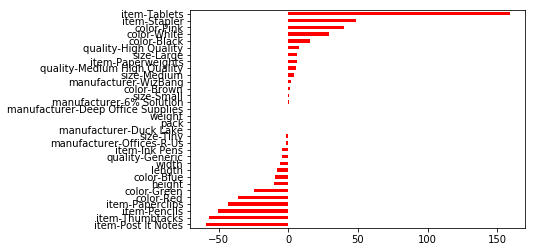

In [70]:
# Simple function to evaluate the coefficients of a regression
%matplotlib inline    
from IPython.display import display, HTML    

def report_coef(names,coef,intercept):
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    print("Intercept: {}".format(intercept))
    r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}))
    
# Create linear regression
regressor = sklearn.linear_model.LinearRegression()

# Fit/train linear regression
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df_train.columns.values)
names.remove("cost")
print(names)
report_coef(
  names,
  regressor.coef_[0,:],
  regressor.intercept_)

In [77]:
checkpoint = ModelCheckpoint(filepath=filename_checkpoint, verbose=0, save_best_only=True)

# Turn off KFold
#if (0):
oos_y = []
oos_pred = []
fold = 0
    
for train, test in kf.split(x):
    fold+=1
    print("Fold #{}".format(fold))
        
    x_train = x[train]
    y_train = y[train]
    x_test = x[test]
    y_test = y[test]
    
    model = Sequential()
    model.add(Dense(50, input_dim=x.shape[1], activation='relu')) # Hidden 1
    model.add(Dropout(0.01)) # Dropout Layer
    model.add(Dense(25, activation='relu')) # Hidden 2
    model.add(Dense(10, 
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01),activation='relu')) # Hidden 3 w/regularization
    model.add(Dense(1)) # Output
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=100, verbose=1, mode='auto')
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpoint],verbose=1,epochs=10000)
    
    pred = model.predict(x_test)
    
    oos_y.append(y_test)
    oos_pred.append(pred)        

    # Measure this fold's RMSE
    score = np.sqrt(metrics.mean_squared_error(pred,y_test))
    print("Fold score (RMSE): {}".format(score))


Fold #1
Train on 8000 samples, validate on 2000 samples
Epoch 1/10000
8000/8000 [==============================] - 1s 132us/step - loss: 9087.6060 - val_loss: 4727.5546
Epoch 2/10000
8000/8000 [==============================] - 0s 57us/step - loss: 5128.4472 - val_loss: 4195.2830
Epoch 3/10000
8000/8000 [==============================] - 0s 55us/step - loss: 4887.6776 - val_loss: 4074.6876
Epoch 4/10000
8000/8000 [==============================] - 0s 56us/step - loss: 4543.0523 - val_loss: 3867.0386
Epoch 5/10000
8000/8000 [==============================] - 0s 54us/step - loss: 4498.9929 - val_loss: 3880.6009
Epoch 6/10000
8000/8000 [==============================] - 0s 55us/step - loss: 4258.6341 - val_loss: 3662.8730
Epoch 7/10000
8000/8000 [==============================] - 0s 58us/step - loss: 4238.9946 - val_loss: 3772.1742
Epoch 8/10000
8000/8000 [==============================] - 1s 66us/step - loss: 4192.3410 - val_loss: 4715.5497
Epoch 9/10000
8000/8000 [======================

8000/8000 [==============================] - 1s 68us/step - loss: 401.3186 - val_loss: 379.3324
Epoch 74/10000
8000/8000 [==============================] - 0s 62us/step - loss: 406.9899 - val_loss: 311.5777
Epoch 75/10000
8000/8000 [==============================] - 0s 51us/step - loss: 362.3116 - val_loss: 395.4599
Epoch 76/10000
8000/8000 [==============================] - 0s 53us/step - loss: 374.2895 - val_loss: 424.0518
Epoch 77/10000
8000/8000 [==============================] - 0s 59us/step - loss: 474.3877 - val_loss: 289.8211
Epoch 78/10000
8000/8000 [==============================] - 0s 59us/step - loss: 368.6504 - val_loss: 575.1914
Epoch 79/10000
8000/8000 [==============================] - 0s 53us/step - loss: 372.4552 - val_loss: 320.0837
Epoch 80/10000
8000/8000 [==============================] - 0s 54us/step - loss: 354.8838 - val_loss: 560.1346
Epoch 81/10000
8000/8000 [==============================] - 0s 55us/step - loss: 440.0429 - val_loss: 754.7149
Epoch 82/10000
8

8000/8000 [==============================] - 0s 57us/step - loss: 318.1251 - val_loss: 285.6510
Epoch 147/10000
8000/8000 [==============================] - 0s 54us/step - loss: 283.1911 - val_loss: 490.4321
Epoch 148/10000
8000/8000 [==============================] - 0s 54us/step - loss: 316.8413 - val_loss: 218.8380
Epoch 149/10000
8000/8000 [==============================] - 0s 55us/step - loss: 305.2237 - val_loss: 268.9140
Epoch 150/10000
8000/8000 [==============================] - 0s 53us/step - loss: 276.1543 - val_loss: 213.4450
Epoch 151/10000
8000/8000 [==============================] - 0s 53us/step - loss: 326.5162 - val_loss: 279.4381
Epoch 152/10000
8000/8000 [==============================] - 0s 61us/step - loss: 262.1422 - val_loss: 296.2502
Epoch 153/10000
8000/8000 [==============================] - 1s 63us/step - loss: 264.0475 - val_loss: 230.2173
Epoch 154/10000
8000/8000 [==============================] - 0s 55us/step - loss: 329.2454 - val_loss: 216.0988
Epoch 15

8000/8000 [==============================] - 0s 54us/step - loss: 236.9322 - val_loss: 219.8030
Epoch 220/10000
8000/8000 [==============================] - 0s 56us/step - loss: 324.3984 - val_loss: 309.9208
Epoch 221/10000
8000/8000 [==============================] - 0s 57us/step - loss: 259.7252 - val_loss: 197.8519
Epoch 222/10000
8000/8000 [==============================] - 0s 55us/step - loss: 266.1147 - val_loss: 186.1478
Epoch 223/10000
8000/8000 [==============================] - 0s 57us/step - loss: 231.6332 - val_loss: 202.1465
Epoch 224/10000
8000/8000 [==============================] - 0s 60us/step - loss: 250.1246 - val_loss: 197.0097
Epoch 225/10000
8000/8000 [==============================] - 0s 53us/step - loss: 220.6025 - val_loss: 222.6516
Epoch 226/10000
8000/8000 [==============================] - 0s 55us/step - loss: 251.7815 - val_loss: 282.5534
Epoch 227/10000
8000/8000 [==============================] - 0s 56us/step - loss: 234.2268 - val_loss: 201.1676
Epoch 22

8000/8000 [==============================] - 0s 59us/step - loss: 298.5787 - val_loss: 195.3978
Epoch 293/10000
8000/8000 [==============================] - 0s 56us/step - loss: 217.2188 - val_loss: 205.7595
Epoch 294/10000
8000/8000 [==============================] - 0s 62us/step - loss: 244.0246 - val_loss: 230.1474
Epoch 295/10000
8000/8000 [==============================] - 0s 56us/step - loss: 214.9462 - val_loss: 183.3504
Epoch 296/10000
8000/8000 [==============================] - 0s 55us/step - loss: 215.6185 - val_loss: 213.8110
Epoch 297/10000
8000/8000 [==============================] - 0s 54us/step - loss: 205.1339 - val_loss: 243.7920
Epoch 298/10000
8000/8000 [==============================] - 0s 54us/step - loss: 206.8719 - val_loss: 225.0199
Epoch 299/10000
8000/8000 [==============================] - 0s 54us/step - loss: 298.7170 - val_loss: 220.1860
Epoch 300/10000
8000/8000 [==============================] - 0s 54us/step - loss: 251.8332 - val_loss: 187.0698
Epoch 30

8000/8000 [==============================] - 0s 57us/step - loss: 224.2450 - val_loss: 180.1033
Epoch 366/10000
8000/8000 [==============================] - 0s 52us/step - loss: 220.1621 - val_loss: 236.2144
Epoch 367/10000
8000/8000 [==============================] - 0s 51us/step - loss: 199.6925 - val_loss: 167.6273
Epoch 368/10000
8000/8000 [==============================] - 0s 54us/step - loss: 264.0801 - val_loss: 178.0069
Epoch 369/10000
8000/8000 [==============================] - 0s 51us/step - loss: 190.4530 - val_loss: 193.9652
Epoch 370/10000
8000/8000 [==============================] - 0s 53us/step - loss: 206.2294 - val_loss: 197.1260
Epoch 371/10000
8000/8000 [==============================] - 1s 65us/step - loss: 197.8840 - val_loss: 191.9187
Epoch 372/10000
8000/8000 [==============================] - 0s 62us/step - loss: 195.2237 - val_loss: 267.7173
Epoch 373/10000
8000/8000 [==============================] - 0s 55us/step - loss: 227.6661 - val_loss: 374.4054
Epoch 37

8000/8000 [==============================] - 0s 53us/step - loss: 192.5283 - val_loss: 202.7875
Epoch 439/10000
8000/8000 [==============================] - 0s 53us/step - loss: 235.4482 - val_loss: 158.3509
Epoch 440/10000
8000/8000 [==============================] - 0s 57us/step - loss: 179.2529 - val_loss: 156.3183
Epoch 441/10000
8000/8000 [==============================] - 0s 53us/step - loss: 195.6247 - val_loss: 159.0178
Epoch 442/10000
8000/8000 [==============================] - 0s 55us/step - loss: 207.5427 - val_loss: 174.6154
Epoch 443/10000
8000/8000 [==============================] - 0s 53us/step - loss: 173.4024 - val_loss: 176.7418
Epoch 444/10000
8000/8000 [==============================] - 0s 52us/step - loss: 188.2973 - val_loss: 191.8959
Epoch 445/10000
8000/8000 [==============================] - 0s 54us/step - loss: 257.9399 - val_loss: 488.8249
Epoch 446/10000
8000/8000 [==============================] - 0s 53us/step - loss: 201.3995 - val_loss: 179.0217
Epoch 44

8000/8000 [==============================] - 0s 52us/step - loss: 198.7578 - val_loss: 192.4123
Epoch 512/10000
8000/8000 [==============================] - 0s 52us/step - loss: 161.7174 - val_loss: 163.8523
Epoch 513/10000
8000/8000 [==============================] - 0s 52us/step - loss: 169.2323 - val_loss: 158.4869
Epoch 514/10000
8000/8000 [==============================] - 0s 53us/step - loss: 243.2781 - val_loss: 162.5664
Epoch 515/10000
8000/8000 [==============================] - 0s 53us/step - loss: 178.1369 - val_loss: 308.6779
Epoch 516/10000
8000/8000 [==============================] - 0s 51us/step - loss: 187.2251 - val_loss: 167.6770
Epoch 517/10000
8000/8000 [==============================] - 0s 52us/step - loss: 171.0627 - val_loss: 155.6382
Epoch 518/10000
8000/8000 [==============================] - 0s 54us/step - loss: 182.2967 - val_loss: 193.2447
Epoch 519/10000
8000/8000 [==============================] - 0s 53us/step - loss: 199.4049 - val_loss: 161.9259
Epoch 52

8000/8000 [==============================] - 0s 53us/step - loss: 187.0675 - val_loss: 166.9737
Epoch 585/10000
8000/8000 [==============================] - 0s 52us/step - loss: 166.4996 - val_loss: 162.9884
Epoch 586/10000
8000/8000 [==============================] - 0s 53us/step - loss: 170.5834 - val_loss: 154.6911
Epoch 587/10000
8000/8000 [==============================] - 0s 54us/step - loss: 164.3343 - val_loss: 198.0332
Epoch 588/10000
8000/8000 [==============================] - 0s 51us/step - loss: 168.4636 - val_loss: 159.0792
Epoch 589/10000
8000/8000 [==============================] - 0s 52us/step - loss: 223.6023 - val_loss: 423.1310
Epoch 590/10000
8000/8000 [==============================] - 0s 52us/step - loss: 194.6413 - val_loss: 156.7971
Epoch 591/10000
8000/8000 [==============================] - 0s 53us/step - loss: 161.4374 - val_loss: 173.2523
Epoch 592/10000
8000/8000 [==============================] - 0s 55us/step - loss: 159.6609 - val_loss: 148.9716
Epoch 59

8000/8000 [==============================] - 0s 55us/step - loss: 263.5421 - val_loss: 198.1430
Epoch 658/10000
8000/8000 [==============================] - 0s 52us/step - loss: 159.7321 - val_loss: 154.4872
Epoch 659/10000
8000/8000 [==============================] - 0s 52us/step - loss: 169.6435 - val_loss: 168.1144
Epoch 660/10000
8000/8000 [==============================] - 0s 53us/step - loss: 151.2153 - val_loss: 153.2468
Epoch 661/10000
8000/8000 [==============================] - 0s 54us/step - loss: 159.9566 - val_loss: 153.1263
Epoch 662/10000
8000/8000 [==============================] - 0s 52us/step - loss: 161.0122 - val_loss: 245.9407
Epoch 663/10000
8000/8000 [==============================] - 0s 54us/step - loss: 210.7789 - val_loss: 823.2889
Epoch 664/10000
8000/8000 [==============================] - 0s 53us/step - loss: 242.7163 - val_loss: 154.8929
Epoch 665/10000
8000/8000 [==============================] - 0s 53us/step - loss: 155.9374 - val_loss: 151.7250
Epoch 66

8000/8000 [==============================] - 0s 55us/step - loss: 639.1530 - val_loss: 467.3266
Epoch 38/10000
8000/8000 [==============================] - 0s 53us/step - loss: 672.6253 - val_loss: 579.2982
Epoch 39/10000
8000/8000 [==============================] - 0s 52us/step - loss: 565.9465 - val_loss: 452.3116
Epoch 40/10000
8000/8000 [==============================] - 0s 52us/step - loss: 625.0120 - val_loss: 434.1672
Epoch 41/10000
8000/8000 [==============================] - 0s 55us/step - loss: 562.9003 - val_loss: 420.6458
Epoch 42/10000
8000/8000 [==============================] - 0s 53us/step - loss: 615.8435 - val_loss: 457.6825
Epoch 43/10000
8000/8000 [==============================] - 0s 54us/step - loss: 622.3603 - val_loss: 1015.6860
Epoch 44/10000
8000/8000 [==============================] - 0s 53us/step - loss: 608.4495 - val_loss: 1133.2287
Epoch 45/10000
8000/8000 [==============================] - 0s 54us/step - loss: 619.2786 - val_loss: 696.4123
Epoch 46/10000

Epoch 111/10000
8000/8000 [==============================] - 0s 54us/step - loss: 376.2172 - val_loss: 384.6584
Epoch 112/10000
8000/8000 [==============================] - 0s 52us/step - loss: 287.3201 - val_loss: 378.3219
Epoch 113/10000
8000/8000 [==============================] - 0s 52us/step - loss: 298.5592 - val_loss: 723.6209
Epoch 114/10000
8000/8000 [==============================] - 0s 53us/step - loss: 376.3027 - val_loss: 271.8724
Epoch 115/10000
8000/8000 [==============================] - 0s 59us/step - loss: 296.8859 - val_loss: 246.7394
Epoch 116/10000
8000/8000 [==============================] - 1s 68us/step - loss: 293.9923 - val_loss: 515.5186
Epoch 117/10000
8000/8000 [==============================] - 1s 72us/step - loss: 395.8083 - val_loss: 304.1520
Epoch 118/10000
8000/8000 [==============================] - 1s 66us/step - loss: 274.5014 - val_loss: 259.3057
Epoch 119/10000
8000/8000 [==============================] - 0s 56us/step - loss: 275.4803 - val_loss: 3

8000/8000 [==============================] - 1s 67us/step - loss: 253.5382 - val_loss: 408.0337
Epoch 185/10000
8000/8000 [==============================] - 1s 69us/step - loss: 278.2610 - val_loss: 282.5854
Epoch 186/10000
8000/8000 [==============================] - 0s 60us/step - loss: 273.2298 - val_loss: 227.6192
Epoch 187/10000
8000/8000 [==============================] - 0s 56us/step - loss: 276.4243 - val_loss: 228.3135
Epoch 188/10000
8000/8000 [==============================] - 0s 53us/step - loss: 236.7369 - val_loss: 220.5367
Epoch 189/10000
8000/8000 [==============================] - 0s 52us/step - loss: 320.3091 - val_loss: 234.9492
Epoch 190/10000
8000/8000 [==============================] - 0s 53us/step - loss: 259.6817 - val_loss: 220.2104
Epoch 191/10000
8000/8000 [==============================] - 0s 54us/step - loss: 244.4428 - val_loss: 237.8504
Epoch 192/10000
8000/8000 [==============================] - 0s 52us/step - loss: 271.5388 - val_loss: 245.9422
Epoch 19

8000/8000 [==============================] - 0s 52us/step - loss: 272.6449 - val_loss: 204.4891
Epoch 258/10000
8000/8000 [==============================] - 0s 52us/step - loss: 215.5849 - val_loss: 214.3077
Epoch 259/10000
8000/8000 [==============================] - 0s 53us/step - loss: 226.4479 - val_loss: 191.5425
Epoch 260/10000
8000/8000 [==============================] - 0s 55us/step - loss: 238.5146 - val_loss: 255.5872
Epoch 261/10000
8000/8000 [==============================] - 0s 53us/step - loss: 237.0043 - val_loss: 191.7207
Epoch 262/10000
8000/8000 [==============================] - 0s 52us/step - loss: 211.9546 - val_loss: 198.3355
Epoch 263/10000
8000/8000 [==============================] - 0s 55us/step - loss: 230.0069 - val_loss: 208.8580
Epoch 264/10000
8000/8000 [==============================] - 0s 52us/step - loss: 248.3023 - val_loss: 204.5367
Epoch 265/10000
8000/8000 [==============================] - 0s 52us/step - loss: 234.5563 - val_loss: 210.3413
Epoch 26

8000/8000 [==============================] - 0s 59us/step - loss: 218.2926 - val_loss: 226.6255
Epoch 331/10000
8000/8000 [==============================] - 1s 63us/step - loss: 219.2079 - val_loss: 194.2979
Epoch 332/10000
8000/8000 [==============================] - 1s 73us/step - loss: 239.2312 - val_loss: 245.4986
Epoch 333/10000
8000/8000 [==============================] - 1s 69us/step - loss: 225.9116 - val_loss: 275.5523
Epoch 334/10000
8000/8000 [==============================] - 0s 54us/step - loss: 231.1828 - val_loss: 240.1334
Epoch 335/10000
8000/8000 [==============================] - 0s 53us/step - loss: 240.2768 - val_loss: 209.0450
Epoch 336/10000
8000/8000 [==============================] - 0s 53us/step - loss: 226.4918 - val_loss: 250.9124
Epoch 337/10000
8000/8000 [==============================] - 0s 57us/step - loss: 248.8531 - val_loss: 188.9410
Epoch 338/10000
8000/8000 [==============================] - 0s 55us/step - loss: 189.1142 - val_loss: 206.8520
Epoch 33

8000/8000 [==============================] - 0s 53us/step - loss: 196.9828 - val_loss: 214.6124
Epoch 404/10000
8000/8000 [==============================] - 0s 52us/step - loss: 211.5487 - val_loss: 218.9691
Epoch 405/10000
8000/8000 [==============================] - 0s 52us/step - loss: 197.8334 - val_loss: 208.7081
Epoch 406/10000
8000/8000 [==============================] - 0s 52us/step - loss: 200.2758 - val_loss: 217.8769
Epoch 407/10000
8000/8000 [==============================] - 0s 52us/step - loss: 184.2838 - val_loss: 175.3165
Epoch 408/10000
8000/8000 [==============================] - 0s 52us/step - loss: 191.8864 - val_loss: 177.5871
Epoch 409/10000
8000/8000 [==============================] - 0s 52us/step - loss: 206.8814 - val_loss: 283.4382
Epoch 410/10000
8000/8000 [==============================] - 0s 53us/step - loss: 196.8880 - val_loss: 240.6018
Epoch 411/10000
8000/8000 [==============================] - 0s 53us/step - loss: 177.6893 - val_loss: 186.2683
Epoch 41

8000/8000 [==============================] - 0s 55us/step - loss: 192.5547 - val_loss: 198.9354
Epoch 477/10000
8000/8000 [==============================] - 0s 53us/step - loss: 321.1726 - val_loss: 172.5170
Epoch 478/10000
8000/8000 [==============================] - 0s 51us/step - loss: 170.2719 - val_loss: 169.7718
Epoch 479/10000
8000/8000 [==============================] - 0s 53us/step - loss: 179.3199 - val_loss: 173.1252
Epoch 480/10000
8000/8000 [==============================] - 0s 53us/step - loss: 179.0072 - val_loss: 182.7882
Epoch 481/10000
8000/8000 [==============================] - 0s 56us/step - loss: 203.8601 - val_loss: 192.0631
Epoch 482/10000
8000/8000 [==============================] - 0s 52us/step - loss: 188.9975 - val_loss: 168.1413
Epoch 483/10000
8000/8000 [==============================] - 0s 57us/step - loss: 170.9413 - val_loss: 215.8539
Epoch 484/10000
8000/8000 [==============================] - 0s 53us/step - loss: 192.6350 - val_loss: 196.3061
Epoch 48

8000/8000 [==============================] - 0s 53us/step - loss: 163.9960 - val_loss: 250.2346
Epoch 550/10000
8000/8000 [==============================] - 0s 55us/step - loss: 179.8378 - val_loss: 172.3825
Epoch 551/10000
8000/8000 [==============================] - 0s 55us/step - loss: 171.4253 - val_loss: 299.3378
Epoch 552/10000
8000/8000 [==============================] - 0s 52us/step - loss: 192.4546 - val_loss: 192.7131
Epoch 553/10000
8000/8000 [==============================] - 0s 53us/step - loss: 283.5285 - val_loss: 269.3007
Epoch 554/10000
8000/8000 [==============================] - 0s 55us/step - loss: 165.5485 - val_loss: 169.7191
Epoch 555/10000
8000/8000 [==============================] - 0s 54us/step - loss: 169.6773 - val_loss: 190.4981
Epoch 556/10000
8000/8000 [==============================] - 0s 54us/step - loss: 159.3413 - val_loss: 162.7338
Epoch 557/10000
8000/8000 [==============================] - 0s 52us/step - loss: 162.7658 - val_loss: 258.2960
Epoch 55

8000/8000 [==============================] - 0s 53us/step - loss: 185.4536 - val_loss: 180.4371
Epoch 623/10000
8000/8000 [==============================] - 0s 54us/step - loss: 167.6222 - val_loss: 267.9542
Epoch 624/10000
8000/8000 [==============================] - 0s 54us/step - loss: 315.5324 - val_loss: 220.9932
Epoch 625/10000
8000/8000 [==============================] - 0s 55us/step - loss: 154.4305 - val_loss: 164.5652
Epoch 626/10000
8000/8000 [==============================] - 0s 52us/step - loss: 167.1875 - val_loss: 177.8337
Epoch 627/10000
8000/8000 [==============================] - 0s 55us/step - loss: 158.9212 - val_loss: 211.7529
Epoch 628/10000
8000/8000 [==============================] - 0s 52us/step - loss: 217.7220 - val_loss: 168.9799
Epoch 629/10000
8000/8000 [==============================] - 0s 53us/step - loss: 175.7554 - val_loss: 167.2476
Epoch 630/10000
8000/8000 [==============================] - 0s 53us/step - loss: 161.3162 - val_loss: 171.1337
Epoch 63

8000/8000 [==============================] - 0s 54us/step - loss: 172.6662 - val_loss: 207.3698
Epoch 696/10000
8000/8000 [==============================] - 0s 52us/step - loss: 157.2455 - val_loss: 163.3132
Epoch 697/10000
8000/8000 [==============================] - 0s 53us/step - loss: 293.0223 - val_loss: 240.3844
Epoch 698/10000
8000/8000 [==============================] - 0s 53us/step - loss: 156.7773 - val_loss: 164.0393
Epoch 699/10000
8000/8000 [==============================] - 0s 54us/step - loss: 154.3539 - val_loss: 181.0124
Epoch 700/10000
8000/8000 [==============================] - 0s 53us/step - loss: 179.1508 - val_loss: 164.2606
Epoch 701/10000
8000/8000 [==============================] - 0s 54us/step - loss: 159.5731 - val_loss: 181.9548
Epoch 702/10000
8000/8000 [==============================] - 0s 54us/step - loss: 168.2317 - val_loss: 176.8116
Epoch 703/10000
8000/8000 [==============================] - 0s 53us/step - loss: 163.0563 - val_loss: 185.8753
Epoch 70

8000/8000 [==============================] - 0s 52us/step - loss: 164.1221 - val_loss: 165.4024
Epoch 769/10000
8000/8000 [==============================] - 0s 54us/step - loss: 173.7241 - val_loss: 339.3930
Epoch 770/10000
8000/8000 [==============================] - 0s 53us/step - loss: 182.2126 - val_loss: 155.9121
Epoch 771/10000
8000/8000 [==============================] - 0s 54us/step - loss: 195.6129 - val_loss: 327.8736
Epoch 772/10000
8000/8000 [==============================] - 0s 53us/step - loss: 434.4585 - val_loss: 409.8568
Epoch 773/10000
8000/8000 [==============================] - 0s 56us/step - loss: 217.2327 - val_loss: 171.3619
Epoch 774/10000
8000/8000 [==============================] - 0s 53us/step - loss: 172.2747 - val_loss: 197.6577
Epoch 775/10000
8000/8000 [==============================] - 0s 60us/step - loss: 162.9041 - val_loss: 325.4372
Epoch 776/10000
8000/8000 [==============================] - 0s 53us/step - loss: 244.2897 - val_loss: 270.2405
Epoch 77

8000/8000 [==============================] - 0s 58us/step - loss: 156.8666 - val_loss: 193.0103
Epoch 842/10000
8000/8000 [==============================] - 0s 54us/step - loss: 165.2415 - val_loss: 240.9594
Epoch 843/10000
8000/8000 [==============================] - 0s 54us/step - loss: 247.5098 - val_loss: 171.4209
Epoch 844/10000
8000/8000 [==============================] - 0s 52us/step - loss: 247.9237 - val_loss: 507.7744
Epoch 845/10000
8000/8000 [==============================] - 0s 58us/step - loss: 182.0022 - val_loss: 157.6811
Epoch 846/10000
8000/8000 [==============================] - 0s 54us/step - loss: 152.9254 - val_loss: 154.3207
Epoch 847/10000
8000/8000 [==============================] - 0s 53us/step - loss: 153.5894 - val_loss: 261.5667
Epoch 848/10000
8000/8000 [==============================] - 0s 54us/step - loss: 157.8825 - val_loss: 176.5684
Epoch 849/10000
8000/8000 [==============================] - 0s 52us/step - loss: 158.0840 - val_loss: 159.1388
Epoch 85

8000/8000 [==============================] - 0s 53us/step - loss: 285.0894 - val_loss: 222.5065
Epoch 915/10000
8000/8000 [==============================] - 0s 53us/step - loss: 164.9235 - val_loss: 156.7537
Epoch 916/10000
8000/8000 [==============================] - 0s 52us/step - loss: 155.0690 - val_loss: 182.9538
Epoch 917/10000
8000/8000 [==============================] - 0s 53us/step - loss: 152.5966 - val_loss: 164.7834
Epoch 918/10000
8000/8000 [==============================] - 0s 53us/step - loss: 191.8643 - val_loss: 184.6973
Epoch 919/10000
8000/8000 [==============================] - 0s 54us/step - loss: 156.0708 - val_loss: 157.6918
Epoch 920/10000
8000/8000 [==============================] - 0s 54us/step - loss: 147.8256 - val_loss: 166.3628
Epoch 921/10000
8000/8000 [==============================] - 0s 53us/step - loss: 181.6514 - val_loss: 215.1368
Epoch 922/10000
8000/8000 [==============================] - 0s 51us/step - loss: 151.8696 - val_loss: 161.6128
Epoch 92

8000/8000 [==============================] - 0s 53us/step - loss: 190.3714 - val_loss: 300.4269
Epoch 988/10000
8000/8000 [==============================] - 0s 52us/step - loss: 192.0688 - val_loss: 181.8448
Epoch 989/10000
8000/8000 [==============================] - 0s 53us/step - loss: 182.9871 - val_loss: 182.9689
Epoch 990/10000
8000/8000 [==============================] - 0s 54us/step - loss: 167.5209 - val_loss: 199.6411
Epoch 991/10000
8000/8000 [==============================] - 0s 53us/step - loss: 177.5185 - val_loss: 168.7337
Epoch 992/10000
8000/8000 [==============================] - 0s 53us/step - loss: 176.4469 - val_loss: 219.1063
Epoch 993/10000
8000/8000 [==============================] - 0s 53us/step - loss: 191.5394 - val_loss: 170.2369
Epoch 994/10000
8000/8000 [==============================] - 0s 54us/step - loss: 180.9462 - val_loss: 185.4239
Epoch 995/10000
8000/8000 [==============================] - 0s 53us/step - loss: 171.8285 - val_loss: 159.2909
Epoch 99

8000/8000 [==============================] - 0s 61us/step - loss: 1306.8118 - val_loss: 1022.6727
Epoch 29/10000
8000/8000 [==============================] - 0s 62us/step - loss: 1162.9849 - val_loss: 900.1195
Epoch 30/10000
8000/8000 [==============================] - 0s 56us/step - loss: 1093.9382 - val_loss: 1333.9789
Epoch 31/10000
8000/8000 [==============================] - 1s 83us/step - loss: 1012.8427 - val_loss: 776.5664
Epoch 32/10000
8000/8000 [==============================] - 1s 87us/step - loss: 959.6779 - val_loss: 658.5132
Epoch 33/10000
8000/8000 [==============================] - 1s 81us/step - loss: 849.1231 - val_loss: 673.1585
Epoch 34/10000
8000/8000 [==============================] - 1s 71us/step - loss: 942.8097 - val_loss: 526.3064
Epoch 35/10000
8000/8000 [==============================] - 1s 68us/step - loss: 876.6846 - val_loss: 930.2483
Epoch 36/10000
8000/8000 [==============================] - 1s 67us/step - loss: 816.7774 - val_loss: 697.0327
Epoch 37/1

Epoch 102/10000
8000/8000 [==============================] - 0s 57us/step - loss: 351.0400 - val_loss: 450.4835
Epoch 103/10000
8000/8000 [==============================] - 0s 54us/step - loss: 335.6866 - val_loss: 642.7327
Epoch 104/10000
8000/8000 [==============================] - 0s 53us/step - loss: 323.3059 - val_loss: 390.2115
Epoch 105/10000
8000/8000 [==============================] - 0s 54us/step - loss: 326.7360 - val_loss: 294.8577
Epoch 106/10000
8000/8000 [==============================] - 0s 54us/step - loss: 298.3902 - val_loss: 235.8666
Epoch 107/10000
8000/8000 [==============================] - 0s 58us/step - loss: 311.8617 - val_loss: 277.3381
Epoch 108/10000
8000/8000 [==============================] - 0s 52us/step - loss: 294.5713 - val_loss: 233.5249
Epoch 109/10000
8000/8000 [==============================] - 0s 54us/step - loss: 301.4492 - val_loss: 274.1356
Epoch 110/10000
8000/8000 [==============================] - 0s 55us/step - loss: 352.6720 - val_loss: 2

8000/8000 [==============================] - 0s 57us/step - loss: 335.6811 - val_loss: 214.7058
Epoch 176/10000
8000/8000 [==============================] - 0s 54us/step - loss: 254.5865 - val_loss: 274.8959
Epoch 177/10000
8000/8000 [==============================] - 0s 55us/step - loss: 268.5845 - val_loss: 206.9293
Epoch 178/10000
8000/8000 [==============================] - 0s 53us/step - loss: 244.7014 - val_loss: 202.1812
Epoch 179/10000
8000/8000 [==============================] - 0s 55us/step - loss: 248.6864 - val_loss: 206.3750
Epoch 180/10000
8000/8000 [==============================] - 0s 54us/step - loss: 250.2904 - val_loss: 202.0115
Epoch 181/10000
8000/8000 [==============================] - 0s 55us/step - loss: 261.9191 - val_loss: 214.0660
Epoch 182/10000
8000/8000 [==============================] - 0s 54us/step - loss: 289.5404 - val_loss: 201.8960
Epoch 183/10000
8000/8000 [==============================] - 0s 53us/step - loss: 268.4101 - val_loss: 300.6155
Epoch 18

8000/8000 [==============================] - 0s 55us/step - loss: 287.7200 - val_loss: 258.7669
Epoch 249/10000
8000/8000 [==============================] - 0s 54us/step - loss: 250.3247 - val_loss: 226.3026
Epoch 250/10000
8000/8000 [==============================] - 0s 53us/step - loss: 239.3987 - val_loss: 181.5336
Epoch 251/10000
8000/8000 [==============================] - 0s 56us/step - loss: 216.5182 - val_loss: 426.2592
Epoch 252/10000
8000/8000 [==============================] - 0s 54us/step - loss: 241.0181 - val_loss: 203.9668
Epoch 253/10000
8000/8000 [==============================] - 0s 61us/step - loss: 216.4759 - val_loss: 176.5054
Epoch 254/10000
8000/8000 [==============================] - 0s 56us/step - loss: 235.0262 - val_loss: 188.8322
Epoch 255/10000
8000/8000 [==============================] - 0s 54us/step - loss: 237.2159 - val_loss: 224.1687
Epoch 256/10000
8000/8000 [==============================] - 0s 57us/step - loss: 231.7727 - val_loss: 201.3633
Epoch 25

8000/8000 [==============================] - 0s 56us/step - loss: 205.3194 - val_loss: 171.5119
Epoch 322/10000
8000/8000 [==============================] - 0s 54us/step - loss: 190.7663 - val_loss: 188.7531
Epoch 323/10000
8000/8000 [==============================] - 0s 58us/step - loss: 192.6488 - val_loss: 167.9484
Epoch 324/10000
8000/8000 [==============================] - 0s 53us/step - loss: 218.2724 - val_loss: 212.5192
Epoch 325/10000
8000/8000 [==============================] - 0s 55us/step - loss: 204.3265 - val_loss: 179.3770
Epoch 326/10000
8000/8000 [==============================] - 0s 54us/step - loss: 328.0348 - val_loss: 194.7310
Epoch 327/10000
8000/8000 [==============================] - 0s 58us/step - loss: 207.1272 - val_loss: 376.5830
Epoch 328/10000
8000/8000 [==============================] - 0s 54us/step - loss: 197.4186 - val_loss: 177.4740
Epoch 329/10000
8000/8000 [==============================] - 0s 55us/step - loss: 186.5222 - val_loss: 169.2847
Epoch 33

8000/8000 [==============================] - 0s 53us/step - loss: 276.1320 - val_loss: 214.3963
Epoch 395/10000
8000/8000 [==============================] - 0s 54us/step - loss: 259.4567 - val_loss: 379.1693
Epoch 396/10000
8000/8000 [==============================] - 0s 54us/step - loss: 233.3254 - val_loss: 192.1327
Epoch 397/10000
8000/8000 [==============================] - 0s 54us/step - loss: 191.4924 - val_loss: 154.4947
Epoch 398/10000
8000/8000 [==============================] - 0s 54us/step - loss: 244.5585 - val_loss: 174.0255
Epoch 399/10000
8000/8000 [==============================] - 0s 55us/step - loss: 189.0993 - val_loss: 214.6554
Epoch 400/10000
8000/8000 [==============================] - 0s 53us/step - loss: 171.9313 - val_loss: 175.9444
Epoch 401/10000
8000/8000 [==============================] - 0s 54us/step - loss: 196.3257 - val_loss: 223.9691
Epoch 402/10000
8000/8000 [==============================] - 0s 53us/step - loss: 235.4149 - val_loss: 193.7731
Epoch 40

8000/8000 [==============================] - 0s 56us/step - loss: 231.1421 - val_loss: 206.5229
Epoch 468/10000
8000/8000 [==============================] - 0s 55us/step - loss: 256.7078 - val_loss: 215.2306
Epoch 469/10000
8000/8000 [==============================] - 0s 54us/step - loss: 224.2070 - val_loss: 162.8252
Epoch 470/10000
8000/8000 [==============================] - 0s 53us/step - loss: 193.6768 - val_loss: 178.3525
Epoch 471/10000
8000/8000 [==============================] - 0s 53us/step - loss: 229.7104 - val_loss: 165.0190
Epoch 472/10000
8000/8000 [==============================] - 0s 55us/step - loss: 207.6498 - val_loss: 197.9960
Epoch 473/10000
8000/8000 [==============================] - 0s 55us/step - loss: 237.9861 - val_loss: 180.6192
Epoch 474/10000
8000/8000 [==============================] - 0s 55us/step - loss: 196.5276 - val_loss: 226.9290
Epoch 475/10000
8000/8000 [==============================] - 0s 54us/step - loss: 272.7939 - val_loss: 497.4510
Epoch 47

8000/8000 [==============================] - 0s 56us/step - loss: 575.4707 - val_loss: 342.5309
Epoch 43/10000
8000/8000 [==============================] - 0s 57us/step - loss: 535.4070 - val_loss: 465.5931
Epoch 44/10000
8000/8000 [==============================] - 0s 55us/step - loss: 534.1892 - val_loss: 354.6426
Epoch 45/10000
8000/8000 [==============================] - 0s 53us/step - loss: 516.2673 - val_loss: 313.6011
Epoch 46/10000
8000/8000 [==============================] - 0s 55us/step - loss: 564.7174 - val_loss: 707.5023
Epoch 47/10000
8000/8000 [==============================] - 0s 55us/step - loss: 715.5784 - val_loss: 1291.9303
Epoch 48/10000
8000/8000 [==============================] - 0s 58us/step - loss: 587.9113 - val_loss: 309.5868
Epoch 49/10000
8000/8000 [==============================] - 0s 53us/step - loss: 550.7847 - val_loss: 981.4338
Epoch 50/10000
8000/8000 [==============================] - 0s 54us/step - loss: 662.3737 - val_loss: 353.6287
Epoch 51/10000


Epoch 116/10000
8000/8000 [==============================] - 0s 55us/step - loss: 330.6084 - val_loss: 220.8807
Epoch 117/10000
8000/8000 [==============================] - 0s 55us/step - loss: 340.2438 - val_loss: 200.2689
Epoch 118/10000
8000/8000 [==============================] - 0s 55us/step - loss: 340.9479 - val_loss: 342.7731
Epoch 119/10000
8000/8000 [==============================] - 0s 53us/step - loss: 301.9552 - val_loss: 282.9543
Epoch 120/10000
8000/8000 [==============================] - 0s 55us/step - loss: 302.7757 - val_loss: 282.8657
Epoch 121/10000
8000/8000 [==============================] - 0s 53us/step - loss: 292.2616 - val_loss: 254.4255
Epoch 122/10000
8000/8000 [==============================] - 0s 55us/step - loss: 304.6955 - val_loss: 253.6522
Epoch 123/10000
8000/8000 [==============================] - 0s 56us/step - loss: 306.9836 - val_loss: 198.6478
Epoch 124/10000
8000/8000 [==============================] - 0s 54us/step - loss: 346.4393 - val_loss: 3

Epoch 189/10000
8000/8000 [==============================] - 1s 73us/step - loss: 284.2972 - val_loss: 232.7180
Epoch 190/10000
8000/8000 [==============================] - 1s 64us/step - loss: 288.2974 - val_loss: 170.4893
Epoch 191/10000
8000/8000 [==============================] - 0s 54us/step - loss: 280.2725 - val_loss: 188.6924
Epoch 192/10000
8000/8000 [==============================] - 0s 53us/step - loss: 291.6082 - val_loss: 196.3799
Epoch 193/10000
8000/8000 [==============================] - 0s 53us/step - loss: 300.4624 - val_loss: 174.9130
Epoch 194/10000
8000/8000 [==============================] - 0s 55us/step - loss: 311.1239 - val_loss: 296.8689
Epoch 195/10000
8000/8000 [==============================] - 0s 54us/step - loss: 259.4921 - val_loss: 168.4080
Epoch 196/10000
8000/8000 [==============================] - 0s 53us/step - loss: 251.8570 - val_loss: 177.9089
Epoch 197/10000
8000/8000 [==============================] - 0s 54us/step - loss: 258.6835 - val_loss: 3

8000/8000 [==============================] - 0s 55us/step - loss: 224.0831 - val_loss: 529.9748
Epoch 263/10000
8000/8000 [==============================] - 0s 54us/step - loss: 364.6000 - val_loss: 197.5314
Epoch 264/10000
8000/8000 [==============================] - 0s 54us/step - loss: 281.3900 - val_loss: 152.0352
Epoch 265/10000
8000/8000 [==============================] - 0s 53us/step - loss: 216.5158 - val_loss: 157.7811
Epoch 266/10000
8000/8000 [==============================] - 0s 55us/step - loss: 242.2910 - val_loss: 299.0766
Epoch 267/10000
8000/8000 [==============================] - 0s 53us/step - loss: 233.6545 - val_loss: 156.2546
Epoch 268/10000
8000/8000 [==============================] - 0s 53us/step - loss: 268.6489 - val_loss: 151.9459
Epoch 269/10000
8000/8000 [==============================] - 0s 57us/step - loss: 276.3896 - val_loss: 198.6162
Epoch 270/10000
8000/8000 [==============================] - 0s 54us/step - loss: 199.9125 - val_loss: 156.2047
Epoch 27

8000/8000 [==============================] - 0s 54us/step - loss: 199.7835 - val_loss: 154.8967
Epoch 336/10000
8000/8000 [==============================] - 0s 55us/step - loss: 193.9675 - val_loss: 210.6713
Epoch 337/10000
8000/8000 [==============================] - 0s 56us/step - loss: 233.3151 - val_loss: 158.2471
Epoch 338/10000
8000/8000 [==============================] - 0s 54us/step - loss: 200.8341 - val_loss: 157.8760
Epoch 339/10000
8000/8000 [==============================] - 0s 55us/step - loss: 243.8524 - val_loss: 311.2494
Epoch 340/10000
8000/8000 [==============================] - 0s 56us/step - loss: 265.9857 - val_loss: 164.8373
Epoch 341/10000
8000/8000 [==============================] - 0s 54us/step - loss: 193.6872 - val_loss: 151.6626
Epoch 342/10000
8000/8000 [==============================] - 1s 63us/step - loss: 207.3625 - val_loss: 141.7482
Epoch 343/10000
8000/8000 [==============================] - 1s 88us/step - loss: 194.3516 - val_loss: 171.8050
Epoch 34

8000/8000 [==============================] - 0s 54us/step - loss: 186.1871 - val_loss: 278.0249
Epoch 409/10000
8000/8000 [==============================] - 0s 57us/step - loss: 249.0784 - val_loss: 140.0868
Epoch 410/10000
8000/8000 [==============================] - 0s 56us/step - loss: 204.8170 - val_loss: 249.4131
Epoch 411/10000
8000/8000 [==============================] - 0s 56us/step - loss: 215.6593 - val_loss: 175.4982
Epoch 412/10000
8000/8000 [==============================] - 0s 54us/step - loss: 205.0973 - val_loss: 150.3753
Epoch 413/10000
8000/8000 [==============================] - 0s 55us/step - loss: 290.0747 - val_loss: 426.3700
Epoch 414/10000
8000/8000 [==============================] - 0s 54us/step - loss: 259.2305 - val_loss: 180.7258
Epoch 415/10000
8000/8000 [==============================] - 0s 55us/step - loss: 202.6267 - val_loss: 168.3071
Epoch 416/10000
8000/8000 [==============================] - 0s 54us/step - loss: 237.2462 - val_loss: 176.8270
Epoch 41

8000/8000 [==============================] - 0s 54us/step - loss: 199.7257 - val_loss: 144.0248
Epoch 482/10000
8000/8000 [==============================] - 0s 58us/step - loss: 192.3003 - val_loss: 157.8435
Epoch 483/10000
8000/8000 [==============================] - 0s 55us/step - loss: 186.5265 - val_loss: 150.1597
Epoch 484/10000
8000/8000 [==============================] - 0s 54us/step - loss: 223.9995 - val_loss: 189.8273
Epoch 485/10000
8000/8000 [==============================] - 0s 55us/step - loss: 244.9795 - val_loss: 260.3800
Epoch 486/10000
8000/8000 [==============================] - 0s 55us/step - loss: 190.2266 - val_loss: 144.1174
Epoch 487/10000
8000/8000 [==============================] - 0s 55us/step - loss: 188.0077 - val_loss: 177.5103
Epoch 488/10000
8000/8000 [==============================] - 0s 56us/step - loss: 200.9115 - val_loss: 147.1779
Epoch 489/10000
8000/8000 [==============================] - 0s 58us/step - loss: 308.8105 - val_loss: 181.5599
Epoch 49

8000/8000 [==============================] - 0s 56us/step - loss: 199.0654 - val_loss: 157.2436
Epoch 555/10000
8000/8000 [==============================] - 0s 53us/step - loss: 227.3846 - val_loss: 185.6161
Epoch 556/10000
8000/8000 [==============================] - 0s 55us/step - loss: 214.3596 - val_loss: 145.8538
Epoch 557/10000
8000/8000 [==============================] - 0s 56us/step - loss: 183.7961 - val_loss: 164.3659
Epoch 558/10000
8000/8000 [==============================] - 0s 55us/step - loss: 190.5362 - val_loss: 134.0280
Epoch 559/10000
8000/8000 [==============================] - 0s 54us/step - loss: 198.1565 - val_loss: 187.8700
Epoch 560/10000
8000/8000 [==============================] - 0s 56us/step - loss: 192.9125 - val_loss: 145.6003
Epoch 561/10000
8000/8000 [==============================] - 0s 52us/step - loss: 180.3793 - val_loss: 201.8546
Epoch 562/10000
8000/8000 [==============================] - 0s 54us/step - loss: 187.5969 - val_loss: 141.9591
Epoch 56

8000/8000 [==============================] - 0s 54us/step - loss: 250.4086 - val_loss: 149.4798
Epoch 628/10000
8000/8000 [==============================] - 0s 58us/step - loss: 174.4930 - val_loss: 138.7691
Epoch 629/10000
8000/8000 [==============================] - 0s 56us/step - loss: 172.9949 - val_loss: 187.7209
Epoch 630/10000
8000/8000 [==============================] - 0s 54us/step - loss: 172.7551 - val_loss: 145.6340
Epoch 631/10000
8000/8000 [==============================] - 0s 55us/step - loss: 339.9187 - val_loss: 298.6485
Epoch 632/10000
8000/8000 [==============================] - 0s 56us/step - loss: 285.0294 - val_loss: 196.3085
Epoch 633/10000
8000/8000 [==============================] - 0s 55us/step - loss: 208.6254 - val_loss: 147.1905
Epoch 634/10000
8000/8000 [==============================] - 0s 56us/step - loss: 218.2617 - val_loss: 138.9683
Epoch 635/10000
8000/8000 [==============================] - 0s 54us/step - loss: 191.5586 - val_loss: 195.3133
Epoch 63

8000/8000 [==============================] - 0s 57us/step - loss: 185.0199 - val_loss: 124.8162
Epoch 701/10000
8000/8000 [==============================] - 0s 54us/step - loss: 165.0668 - val_loss: 131.0164
Epoch 702/10000
8000/8000 [==============================] - 0s 55us/step - loss: 162.1593 - val_loss: 123.7104
Epoch 703/10000
8000/8000 [==============================] - 0s 54us/step - loss: 178.0710 - val_loss: 152.5851
Epoch 704/10000
8000/8000 [==============================] - 0s 54us/step - loss: 201.1521 - val_loss: 135.9301
Epoch 705/10000
8000/8000 [==============================] - 0s 58us/step - loss: 319.6342 - val_loss: 336.5116
Epoch 706/10000
8000/8000 [==============================] - 0s 60us/step - loss: 221.5618 - val_loss: 167.3669
Epoch 707/10000
8000/8000 [==============================] - 0s 56us/step - loss: 188.7189 - val_loss: 130.0960
Epoch 708/10000
8000/8000 [==============================] - 0s 55us/step - loss: 170.1062 - val_loss: 132.8046
Epoch 70

8000/8000 [==============================] - 0s 55us/step - loss: 175.2737 - val_loss: 136.2378
Epoch 774/10000
8000/8000 [==============================] - 0s 54us/step - loss: 169.3500 - val_loss: 130.4971
Epoch 775/10000
8000/8000 [==============================] - 0s 54us/step - loss: 218.6320 - val_loss: 132.0642
Epoch 776/10000
8000/8000 [==============================] - 0s 52us/step - loss: 205.1543 - val_loss: 226.3217
Epoch 777/10000
8000/8000 [==============================] - 0s 55us/step - loss: 183.4070 - val_loss: 128.9832
Epoch 778/10000
8000/8000 [==============================] - 0s 57us/step - loss: 163.7820 - val_loss: 139.4821
Epoch 779/10000
8000/8000 [==============================] - 0s 53us/step - loss: 167.9872 - val_loss: 125.2236
Epoch 780/10000
8000/8000 [==============================] - 0s 55us/step - loss: 156.3649 - val_loss: 148.2883
Epoch 781/10000
8000/8000 [==============================] - 0s 57us/step - loss: 240.1287 - val_loss: 152.8827
Epoch 78

8000/8000 [==============================] - 1s 66us/step - loss: 579.5187 - val_loss: 391.1043
Epoch 44/10000
8000/8000 [==============================] - 1s 73us/step - loss: 533.0719 - val_loss: 743.3650
Epoch 45/10000
8000/8000 [==============================] - 1s 72us/step - loss: 652.7924 - val_loss: 363.5605
Epoch 46/10000
8000/8000 [==============================] - 0s 61us/step - loss: 545.7218 - val_loss: 334.2523
Epoch 47/10000
8000/8000 [==============================] - 0s 56us/step - loss: 475.6481 - val_loss: 323.3740
Epoch 48/10000
8000/8000 [==============================] - 0s 54us/step - loss: 593.7055 - val_loss: 335.5636
Epoch 49/10000
8000/8000 [==============================] - 0s 55us/step - loss: 502.6638 - val_loss: 311.8110
Epoch 50/10000
8000/8000 [==============================] - 0s 58us/step - loss: 481.9155 - val_loss: 339.8681
Epoch 51/10000
8000/8000 [==============================] - 0s 57us/step - loss: 518.5355 - val_loss: 343.0354
Epoch 52/10000
8

Epoch 117/10000
8000/8000 [==============================] - 0s 55us/step - loss: 303.3643 - val_loss: 200.4073
Epoch 118/10000
8000/8000 [==============================] - 0s 55us/step - loss: 279.2296 - val_loss: 208.4546
Epoch 119/10000
8000/8000 [==============================] - 0s 54us/step - loss: 294.0148 - val_loss: 207.7133
Epoch 120/10000
8000/8000 [==============================] - 0s 54us/step - loss: 338.8406 - val_loss: 188.5180
Epoch 121/10000
8000/8000 [==============================] - 0s 57us/step - loss: 327.0331 - val_loss: 451.1933
Epoch 122/10000
8000/8000 [==============================] - 0s 54us/step - loss: 298.4565 - val_loss: 199.3454
Epoch 123/10000
8000/8000 [==============================] - 0s 54us/step - loss: 297.8372 - val_loss: 212.5485
Epoch 124/10000
8000/8000 [==============================] - 0s 54us/step - loss: 288.4605 - val_loss: 329.9680
Epoch 125/10000
8000/8000 [==============================] - 0s 53us/step - loss: 314.6357 - val_loss: 2

Epoch 190/10000
8000/8000 [==============================] - 0s 54us/step - loss: 250.8159 - val_loss: 170.6979
Epoch 191/10000
8000/8000 [==============================] - 0s 56us/step - loss: 266.4237 - val_loss: 200.5782
Epoch 192/10000
8000/8000 [==============================] - 0s 54us/step - loss: 257.1043 - val_loss: 211.3023
Epoch 193/10000
8000/8000 [==============================] - 0s 56us/step - loss: 256.0356 - val_loss: 215.1753
Epoch 194/10000
8000/8000 [==============================] - 0s 54us/step - loss: 276.8350 - val_loss: 181.7793
Epoch 195/10000
8000/8000 [==============================] - 0s 56us/step - loss: 379.2979 - val_loss: 277.6853
Epoch 196/10000
8000/8000 [==============================] - 0s 54us/step - loss: 417.2015 - val_loss: 261.0164
Epoch 197/10000
8000/8000 [==============================] - 0s 53us/step - loss: 265.3008 - val_loss: 234.2851
Epoch 198/10000
8000/8000 [==============================] - 0s 54us/step - loss: 235.6953 - val_loss: 1

8000/8000 [==============================] - 0s 54us/step - loss: 294.2128 - val_loss: 178.9618
Epoch 264/10000
8000/8000 [==============================] - 0s 53us/step - loss: 262.2457 - val_loss: 184.2750
Epoch 265/10000
8000/8000 [==============================] - 0s 54us/step - loss: 263.0855 - val_loss: 736.0339
Epoch 266/10000
8000/8000 [==============================] - 0s 54us/step - loss: 320.1837 - val_loss: 174.2123
Epoch 267/10000
8000/8000 [==============================] - 0s 54us/step - loss: 260.1659 - val_loss: 162.7452
Epoch 268/10000
8000/8000 [==============================] - 0s 59us/step - loss: 246.4268 - val_loss: 156.3244
Epoch 269/10000
8000/8000 [==============================] - 0s 54us/step - loss: 268.7860 - val_loss: 174.2113
Epoch 270/10000
8000/8000 [==============================] - 0s 55us/step - loss: 251.7035 - val_loss: 195.1298
Epoch 271/10000
8000/8000 [==============================] - 0s 55us/step - loss: 250.4296 - val_loss: 166.8403
Epoch 27

8000/8000 [==============================] - 0s 59us/step - loss: 214.1609 - val_loss: 169.1652
Epoch 337/10000
8000/8000 [==============================] - 0s 54us/step - loss: 202.7111 - val_loss: 176.4627
Epoch 338/10000
8000/8000 [==============================] - 0s 57us/step - loss: 214.5856 - val_loss: 156.0571
Epoch 339/10000
8000/8000 [==============================] - 0s 56us/step - loss: 228.8404 - val_loss: 228.6073
Epoch 340/10000
8000/8000 [==============================] - 0s 55us/step - loss: 232.0522 - val_loss: 144.6087
Epoch 341/10000
8000/8000 [==============================] - 0s 54us/step - loss: 227.4078 - val_loss: 141.0219
Epoch 342/10000
8000/8000 [==============================] - 0s 53us/step - loss: 194.8645 - val_loss: 183.4460
Epoch 343/10000
8000/8000 [==============================] - 0s 54us/step - loss: 192.1028 - val_loss: 143.9101
Epoch 344/10000
8000/8000 [==============================] - 0s 55us/step - loss: 234.6500 - val_loss: 173.8829
Epoch 34

8000/8000 [==============================] - 0s 54us/step - loss: 189.5982 - val_loss: 223.5427
Epoch 410/10000
8000/8000 [==============================] - 0s 55us/step - loss: 210.6459 - val_loss: 171.9331
Epoch 411/10000
8000/8000 [==============================] - 0s 55us/step - loss: 191.7775 - val_loss: 137.6152
Epoch 412/10000
8000/8000 [==============================] - 0s 57us/step - loss: 227.5709 - val_loss: 146.0837
Epoch 413/10000
8000/8000 [==============================] - 0s 54us/step - loss: 189.2655 - val_loss: 210.8279
Epoch 414/10000
8000/8000 [==============================] - 0s 54us/step - loss: 207.6368 - val_loss: 139.5763
Epoch 415/10000
8000/8000 [==============================] - 0s 54us/step - loss: 219.8391 - val_loss: 364.7662
Epoch 416/10000
8000/8000 [==============================] - 0s 56us/step - loss: 284.0499 - val_loss: 150.6107
Epoch 417/10000
8000/8000 [==============================] - 0s 54us/step - loss: 197.2691 - val_loss: 137.0518
Epoch 41

8000/8000 [==============================] - 0s 55us/step - loss: 284.5790 - val_loss: 181.0564
Epoch 483/10000
8000/8000 [==============================] - 0s 55us/step - loss: 295.7732 - val_loss: 243.3333
Epoch 484/10000
8000/8000 [==============================] - 0s 55us/step - loss: 236.2131 - val_loss: 163.9238
Epoch 485/10000
8000/8000 [==============================] - 0s 58us/step - loss: 218.6311 - val_loss: 203.6891
Epoch 486/10000
8000/8000 [==============================] - 0s 55us/step - loss: 213.2354 - val_loss: 168.8732
Epoch 487/10000
8000/8000 [==============================] - 0s 55us/step - loss: 241.4776 - val_loss: 198.1552
Epoch 488/10000
8000/8000 [==============================] - 0s 53us/step - loss: 221.2945 - val_loss: 142.4323
Epoch 489/10000
8000/8000 [==============================] - 1s 65us/step - loss: 202.8567 - val_loss: 338.3459
Epoch 490/10000
8000/8000 [==============================] - 0s 56us/step - loss: 222.6904 - val_loss: 135.4874
Epoch 49

8000/8000 [==============================] - 0s 54us/step - loss: 243.6618 - val_loss: 166.5235
Epoch 556/10000
8000/8000 [==============================] - 0s 55us/step - loss: 183.7218 - val_loss: 132.6357
Epoch 557/10000
8000/8000 [==============================] - 0s 54us/step - loss: 172.4459 - val_loss: 196.5880
Epoch 558/10000
8000/8000 [==============================] - 0s 53us/step - loss: 199.9521 - val_loss: 148.1248
Epoch 559/10000
8000/8000 [==============================] - 0s 55us/step - loss: 173.5342 - val_loss: 203.8592
Epoch 560/10000
8000/8000 [==============================] - 0s 55us/step - loss: 170.3446 - val_loss: 148.0184
Epoch 561/10000
8000/8000 [==============================] - 0s 55us/step - loss: 179.2436 - val_loss: 141.4069
Epoch 562/10000
8000/8000 [==============================] - 0s 54us/step - loss: 179.1313 - val_loss: 135.0692
Epoch 563/10000
8000/8000 [==============================] - 0s 54us/step - loss: 192.3773 - val_loss: 149.3904
Epoch 56

8000/8000 [==============================] - 0s 54us/step - loss: 196.4917 - val_loss: 145.3059
Epoch 629/10000
8000/8000 [==============================] - 0s 54us/step - loss: 201.8019 - val_loss: 173.6750
Epoch 630/10000
8000/8000 [==============================] - 0s 56us/step - loss: 183.9776 - val_loss: 143.1315
Epoch 631/10000
8000/8000 [==============================] - 0s 54us/step - loss: 183.4236 - val_loss: 187.7093
Epoch 632/10000
8000/8000 [==============================] - 0s 55us/step - loss: 225.1083 - val_loss: 245.7738
Epoch 00632: early stopping
Fold score (RMSE): 15.040975570678711


In [13]:
# Build the oos prediction list and calculate the error.
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
score = np.sqrt(metrics.mean_squared_error(oos_pred,oos_y))
print("Final, out of sample score (RMSE): {}".format(score)) 

Final, out of sample score (RMSE): 12.102914810180664


In [20]:

#pred = model.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
#score = np.sqrt(metrics.mean_squared_error(pred,y_test))
#print("Final score (RMSE): {}".format(score))

#chart_regression(pred.flatten(),y_test)
#chart_regression(pred.flatten(),y_test,sort=False)

In [73]:
model.load_weights(filename_checkpoint)

df_test = pd.read_csv(filename_test,na_values=['NA','?'])

extract_and_encode_features(df_test)

ids_test = df_test['id']
df_test.drop('id',1,inplace=True)

names_test = df_test['name']
df_test.drop('name',1,inplace=True)

x_submit = df_test.as_matrix().astype(np.float32)
pred_submit = model.predict(x_submit)


In [74]:
cost = [n if n > 0 else 0 for n in pred_submit[:,0]]
df_submit = pd.DataFrame({'id': ids_test,'cost': cost})
df_submit = df_submit[['id', 'cost']]
df_submit.to_csv(filename_submit, index=False)